<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

random.seed(42)
np.random.seed(42)

In [5]:
from fastapi import FastAPI
from pydantic import BaseModel, model_validator, parse_obj_as
from typing import List
import pandas as pd
import numpy as np
import re
import pickle
import csv

### **Задание 0**
Для чего фиксируем сиды в домашках?

Для вопспроизводимости результатов, и чтобы корректно сравнивать модели между собой. Ракзбиение датасета, инициализации весов и т.п.

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [498]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [499]:
df_train.isna().apply(any)

name             False
year             False
selling_price    False
km_driven        False
fuel             False
seller_type      False
transmission     False
owner            False
mileage           True
engine            True
max_power         True
torque            True
seats             True
dtype: bool

In [500]:
df_train.duplicated().any()

np.True_

In [502]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df_train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

есть пропуски, нужно смотреть, дропать или заполнять.   
есть признаки с высокой корреляцией  
selling_price выглядик как с выбросами. Нужно посмотреть внимательнее  

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [504]:
cat_col = ['fuel', 'seller_type', 'transmission', 'owner']

In [505]:
%config InteractiveShell.ast_node_interactivity = 'all'

In [506]:
df_train.describe()
df_test.describe()

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

In [507]:
df_train.describe().loc[['mean', '50%']]
df_test.describe().loc[['mean', '50%']]

year  selling_price     km_driven     seats
mean  2013.818403  639515.197171  69584.615517  5.419008
50%   2015.000000  450000.000000  60000.000000  5.000000

year  selling_price  km_driven     seats
mean  2013.681     617901.042  71393.341  5.410805
50%   2014.000     434999.000  61500.000  5.000000

Порядки значений для train и test лежал в одинаковых порядках. Выгляит как   
даннный из одного распределения. Все норм.

In [509]:
df_train[cat_col].astype('category').describe()
df_test[cat_col].astype('category').describe()

fuel seller_type transmission        owner
count     6999        6999         6999         6999
unique       4           3            2            5
top     Diesel  Individual       Manual  First Owner
freq      3793        5826         6095         4587

fuel seller_type transmission        owner
count     1000        1000         1000         1000
unique       4           3            2            5
top     Diesel  Individual       Manual  First Owner
freq       534         837          877          623

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [511]:
df_train.drop('selling_price', axis=1).duplicated().sum()

np.int64(1159)

In [512]:
df_train[df_train.drop('selling_price', axis=1).duplicated()]

name  year  selling_price  \
254                   Hyundai Grand i10 Sportz  2017         450000   
258                           Maruti Swift VXI  2012         330000   
268                     Maruti Swift Dzire VXI  2014         400000   
324   Jaguar XE 2016-2019 2.0L Diesel Prestige  2017        2625000   
325                              Lexus ES 300h  2019        5150000   
...                                        ...   ...            ...   
6947                    Chevrolet Spark 1.0 LS  2010         140000   
6984  Ford Freestyle Titanium Plus Diesel BSIV  2018         746000   
6989                    Maruti Swift Dzire VDI  2015         625000   
6997                           Tata Indigo CR4  2013         290000   
6998                           Tata Indigo CR4  2013         290000   

      km_driven    fuel seller_type transmission         owner     mileage  \
254       35000  Petrol  Individual       Manual   First Owner   18.9 kmpl   
258       50000  Petrol  Individual       Manual  Second Owner   18.6 kmpl   
268       70000  Petrol  Individual       Manual  Second Owner   19.1 kmpl   
324        9000  Diesel      Dealer    Automatic   First Owner   13.6 kmpl   
325       20000  Petrol      Dealer    Automatic   First Owner  22.37 kmpl   
...         ...     ...         ...          ...           ...         ...   
6947      60000  Petrol  Individual       Manual  Second Owner   18.0 kmpl   
6984      24000  Diesel  Individual       Manual   First Owner   24.4 kmpl   
6989      50000  Diesel  Individual       Manual   First Owner  26.59 kmpl   
6997      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   
6998      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   

       engine   max_power               torque  seats  
254   1197 CC      82 bhp       114Nm@ 4000rpm    5.0  
258   1197 CC    85.8 bhp       114Nm@ 4000rpm    5.0  
268   1197 CC    85.8 bhp       114Nm@ 4000rpm    5.0  
324   1999 CC     177 bhp  430Nm@ 1750-2500rpm    5.0  
325   2487 CC  214.56 bhp  202Nm@ 3600-5200rpm    5.0  
...       ...         ...                  ...    ...  
6947   995 CC      62 bhp      90.3Nm@ 4200rpm    5.0  
6984  1498 CC   98.63 bhp  215Nm@ 1750-3000rpm    5.0  
6989  1248 CC      74 bhp       190Nm@ 2000rpm    5.0  
6997  1396 CC      70 bhp  140Nm@ 1800-3000rpm    5.0  
6998  1396 CC      70 bhp  140Nm@ 1800-3000rpm    5.0  

[1159 rows x 13 columns]

In [513]:
df_train = df_train.sample(frac=1.0, random_state=42).drop_duplicates(subset=df_train.drop('selling_price', axis=1).columns, keep='first').reset_index(drop=True)

In [515]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [516]:
from typing import List
import regex as re

def convert_mileage_engine_max_power(value):
    if isinstance(value, str):
        num_value = re.search('(\d+\.*\d*)', value)
        if num_value is None:
            return None
        else:
            num_value = num_value.group()
        dim_of_value = value.replace(num_value, '').strip()
        if dim_of_value.startswith('km') and dim_of_value.endswith('kg'):
            return float(num_value) * 1.4
        else:
            return float(num_value)
    elif isinstance(value, float | int):
        return float(value)
    else:
        return None        
    

In [517]:

for col in ['mileage', 'engine', 'max_power']:
    df_train[col] = df_train[col].apply(convert_mileage_engine_max_power)
    df_test[col] = df_test[col].apply(convert_mileage_engine_max_power)

df_train.rename(columns={'max_power':'max_power_bhp', 'engine':'engine_CC', 'mileage':"mileage_kmpl"}, inplace=True)
df_test.rename(columns={'max_power':'max_power_bhp', 'engine':'engine_CC', 'mileage':"mileage_kmpl"}, inplace=True)

In [518]:
def split_torque(value):
    if pd.isna(value): return None, None
    res_nums = [float(i.replace(',', '')) for i in re.findall('([0-9]+[.,]*[0-9]*)\D*', value)]
    res_dims = re.findall('[a-zA-Z]+', value)
    assert 1 <= len(res_nums) <= 3
    if len(res_nums) == 2:
        torque_num, max_torque_rpm_num = res_nums[0], res_nums[-1]
    elif len(res_nums) >= 2:
        torque_num, max_torque_rpm_num = res_nums[0], sum(res_nums[-2:])/2
    else:
        torque_num, max_torque_rpm_num = res_nums[0], None
    if len(res_dims) >= 2:
        torque_dim, max_torque_rpm_dim = res_dims[0], res_dims[-1]
    else:
        return None, None
    assert max_torque_rpm_dim.lower() == 'rpm'
    if torque_dim.lower() == 'kgm':
        torque_num *= 9.80665
        torque_dim = 'Nm'
    return torque_num, max_torque_rpm_num
    

In [519]:
df_train[['torque_Nm', 'max_torque_rpm']] = df_train.torque.apply(split_torque).tolist()
df_test[['torque_Nm', 'max_torque_rpm']] = df_test.torque.apply(split_torque).tolist()
df_train = df_train.drop('torque', axis=1)
df_test = df_test.drop('torque', axis=1)

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [521]:
median_val = df_train.select_dtypes(include=np.number).apply(lambda x: x.median(), axis=0).to_dict()

In [522]:
df_train = df_train.fillna(value=median_val)

In [523]:
df_test = df_test.fillna(value=median_val)

Считать нужно по трейну, т.к. у нас нет теста в реальном времени. Обучение и модель будут смещенными  
И мы получим не правильную оценку модели на валидации.  

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [526]:
df_train[['engine_CC', 'seats']] = df_train[['engine_CC', 'seats']].astype(int)
df_test[['engine_CC', 'seats']] = df_test[['engine_CC', 'seats']].astype(int)

Кол-во мест в машине ограничено и хорошо кластеризуется, например 2, 5, 9 и более  
можно по таким категориям разбить и у нас будет категориальная переменная  

`Your answer here`

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [529]:
df_train.describe()

year  selling_price     km_driven  mileage_kmpl    engine_CC  \
count  5840.000000   5.840000e+03  5.840000e+03   5840.000000  5840.000000   
mean   2013.428425   5.226996e+05  7.395224e+04     19.547135  1429.448973   
std       4.095622   5.346727e+05  6.007114e+04      4.228290   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00      0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04     17.000000  1197.000000   
50%    2014.000000   4.045000e+05  7.000000e+04     19.400000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05     22.320000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06     46.816000  3604.000000   

       max_power_bhp        seats    torque_Nm  max_torque_rpm  
count    5840.000000  5840.000000  5840.000000     5840.000000  
mean       87.906371     5.426712   175.106381     2846.628399  
std        31.640418     0.982344   106.921989      972.914965  
min         0.000000     2.000000    47.071920     1269.350000  
25%        68.000000     5.000000   111.800000     2000.000000  
50%        81.860000     5.000000   160.000000     2400.000000  
75%        99.000000     5.000000   200.000000     3750.000000  
max       400.000000    14.000000  1863.263500    21800.000000

заполнение пропусков могла сдвинуть наше распределение, т.к. мы заполняем медианой,  
а наше распредиление пуасона, тогда мы сместим наше среднее. Также мы удалили дубликаты  
опять же сдвинули к реальному расперделению  

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

In [531]:
import seaborn as sns

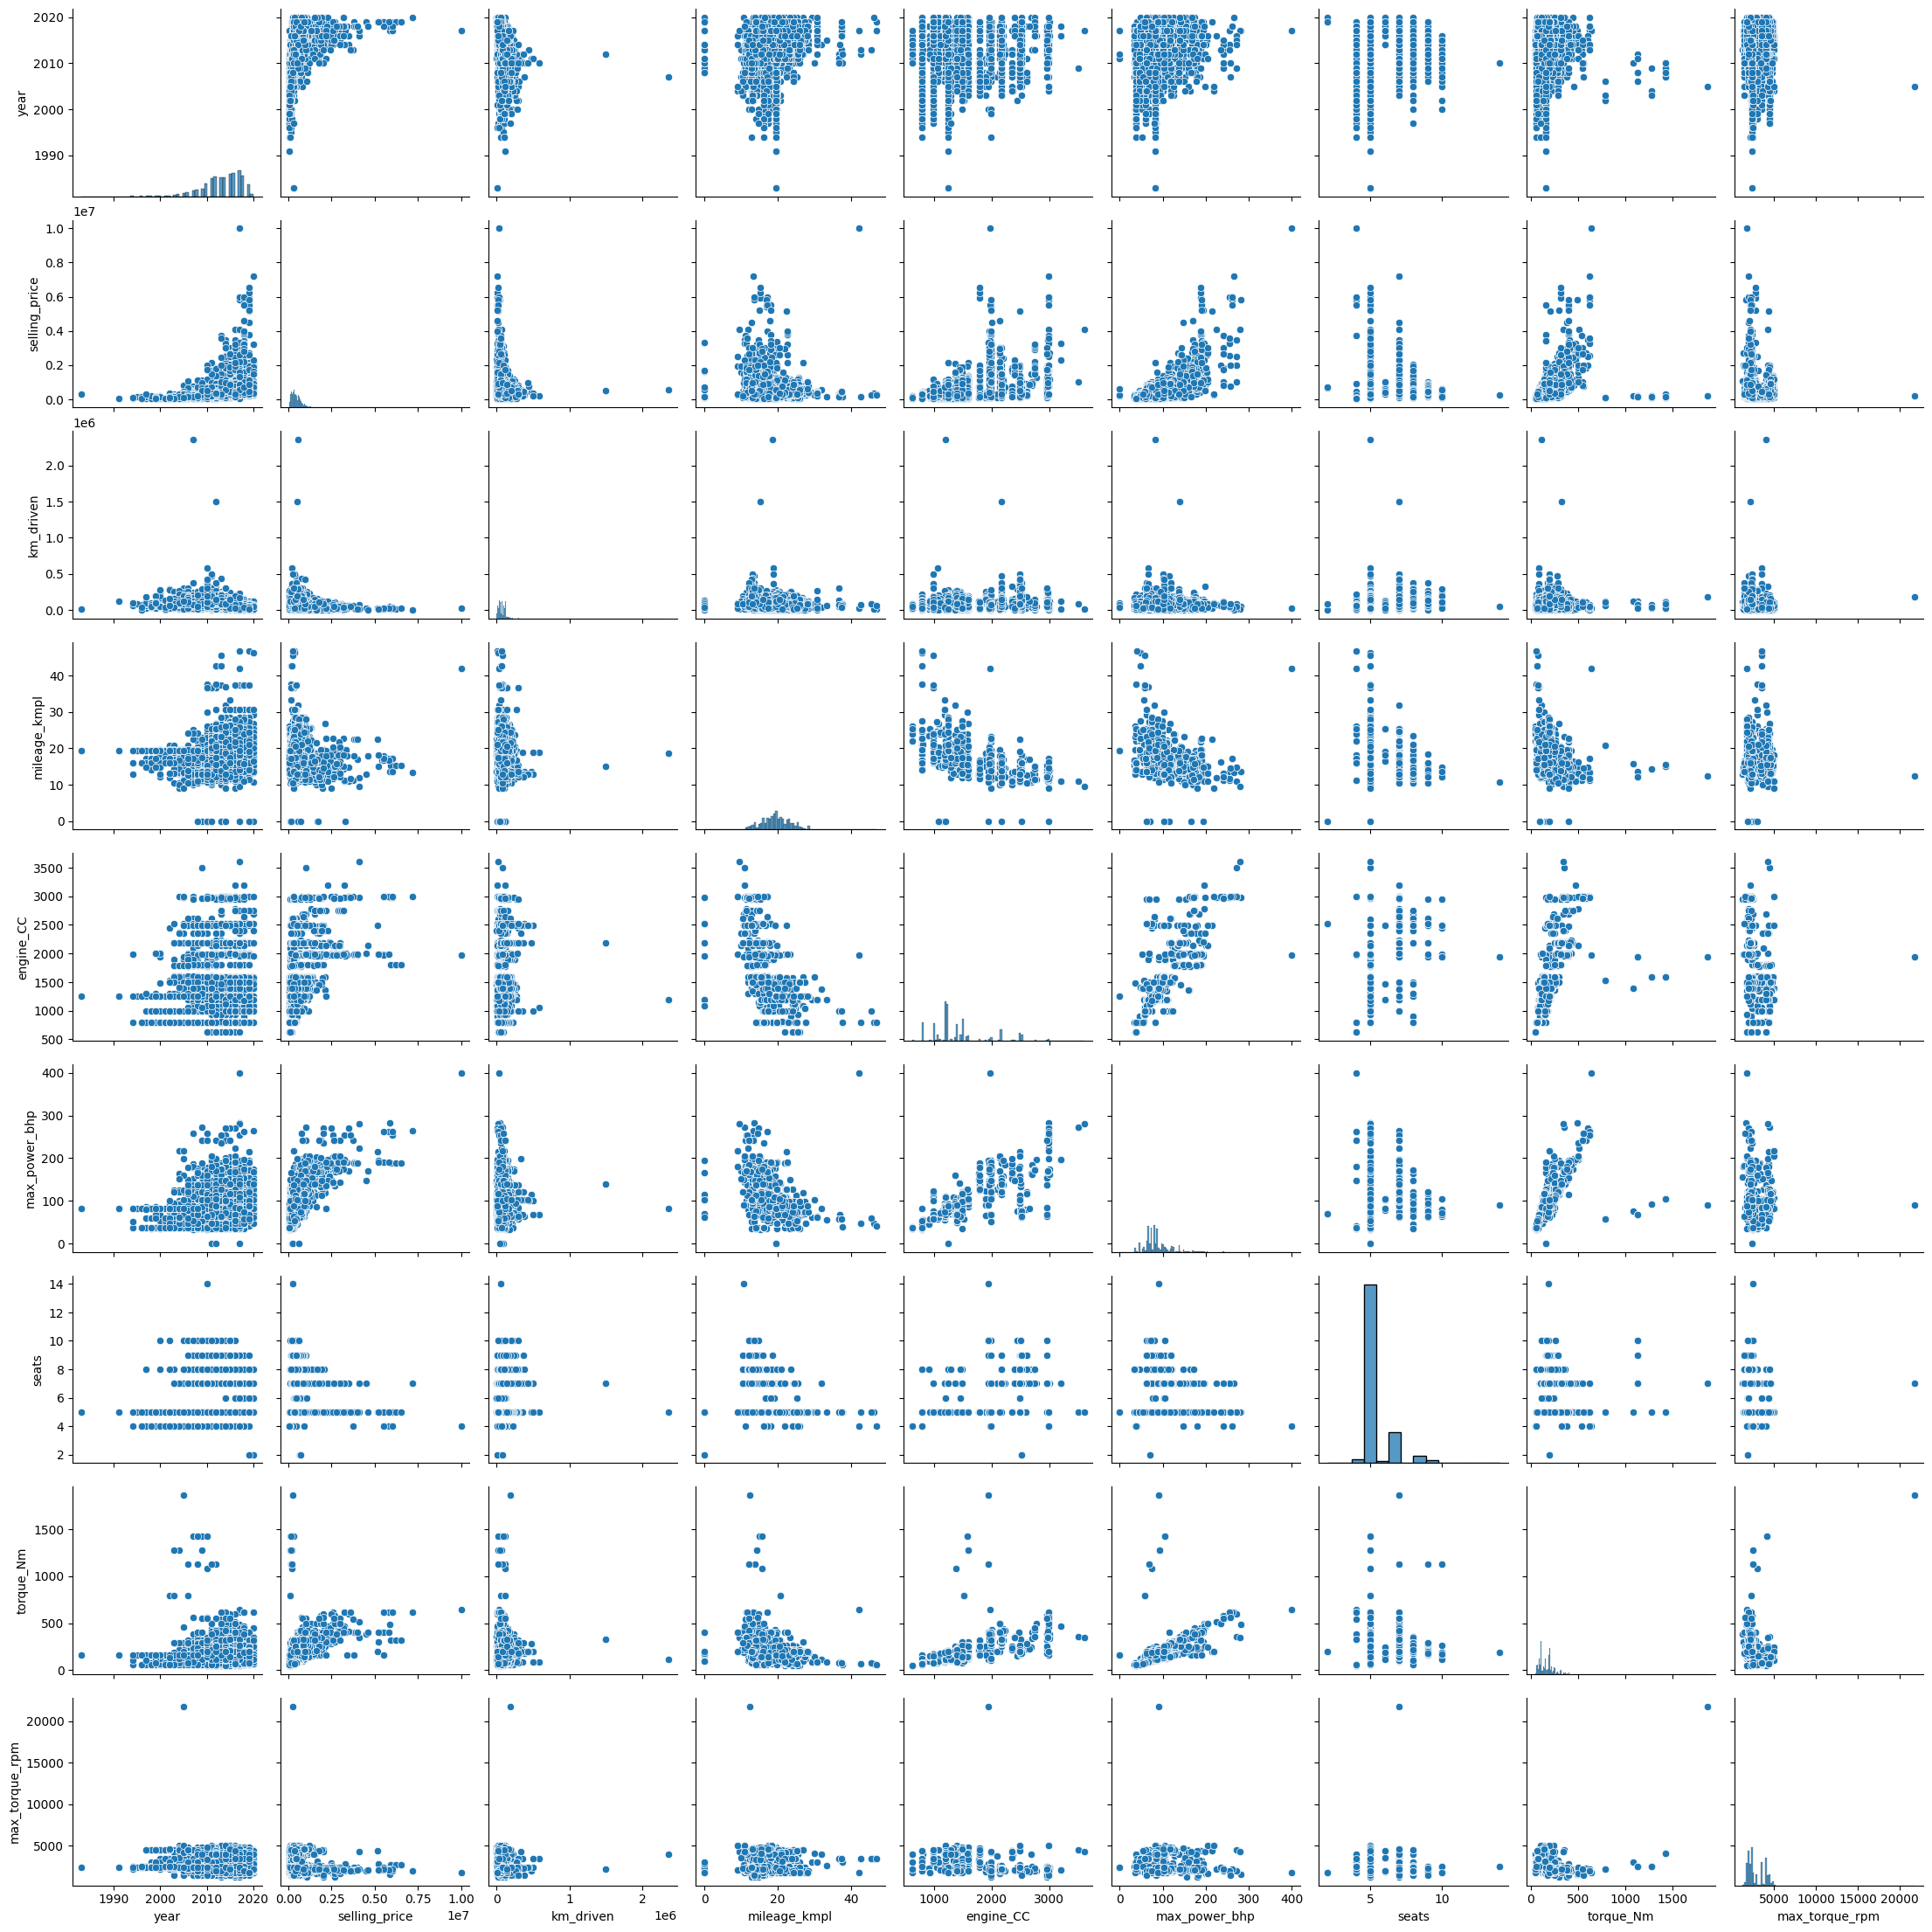

In [532]:
sns.pairplot(df_train)

Да, можно.   
selling_price <-> year  
selling_price <-> km_driven  
selling_price <-> torque_Nm  
  
Да, можно.  
Мы и хотим иметь как можно больше независимых между собой признаков   
с высокой корр с целевым  
  
Например: чем старше машина, тем её относительная цена ниже.   
При прочих равных, машина с большим пробегом стоит дешевле  
и т.п.  
  

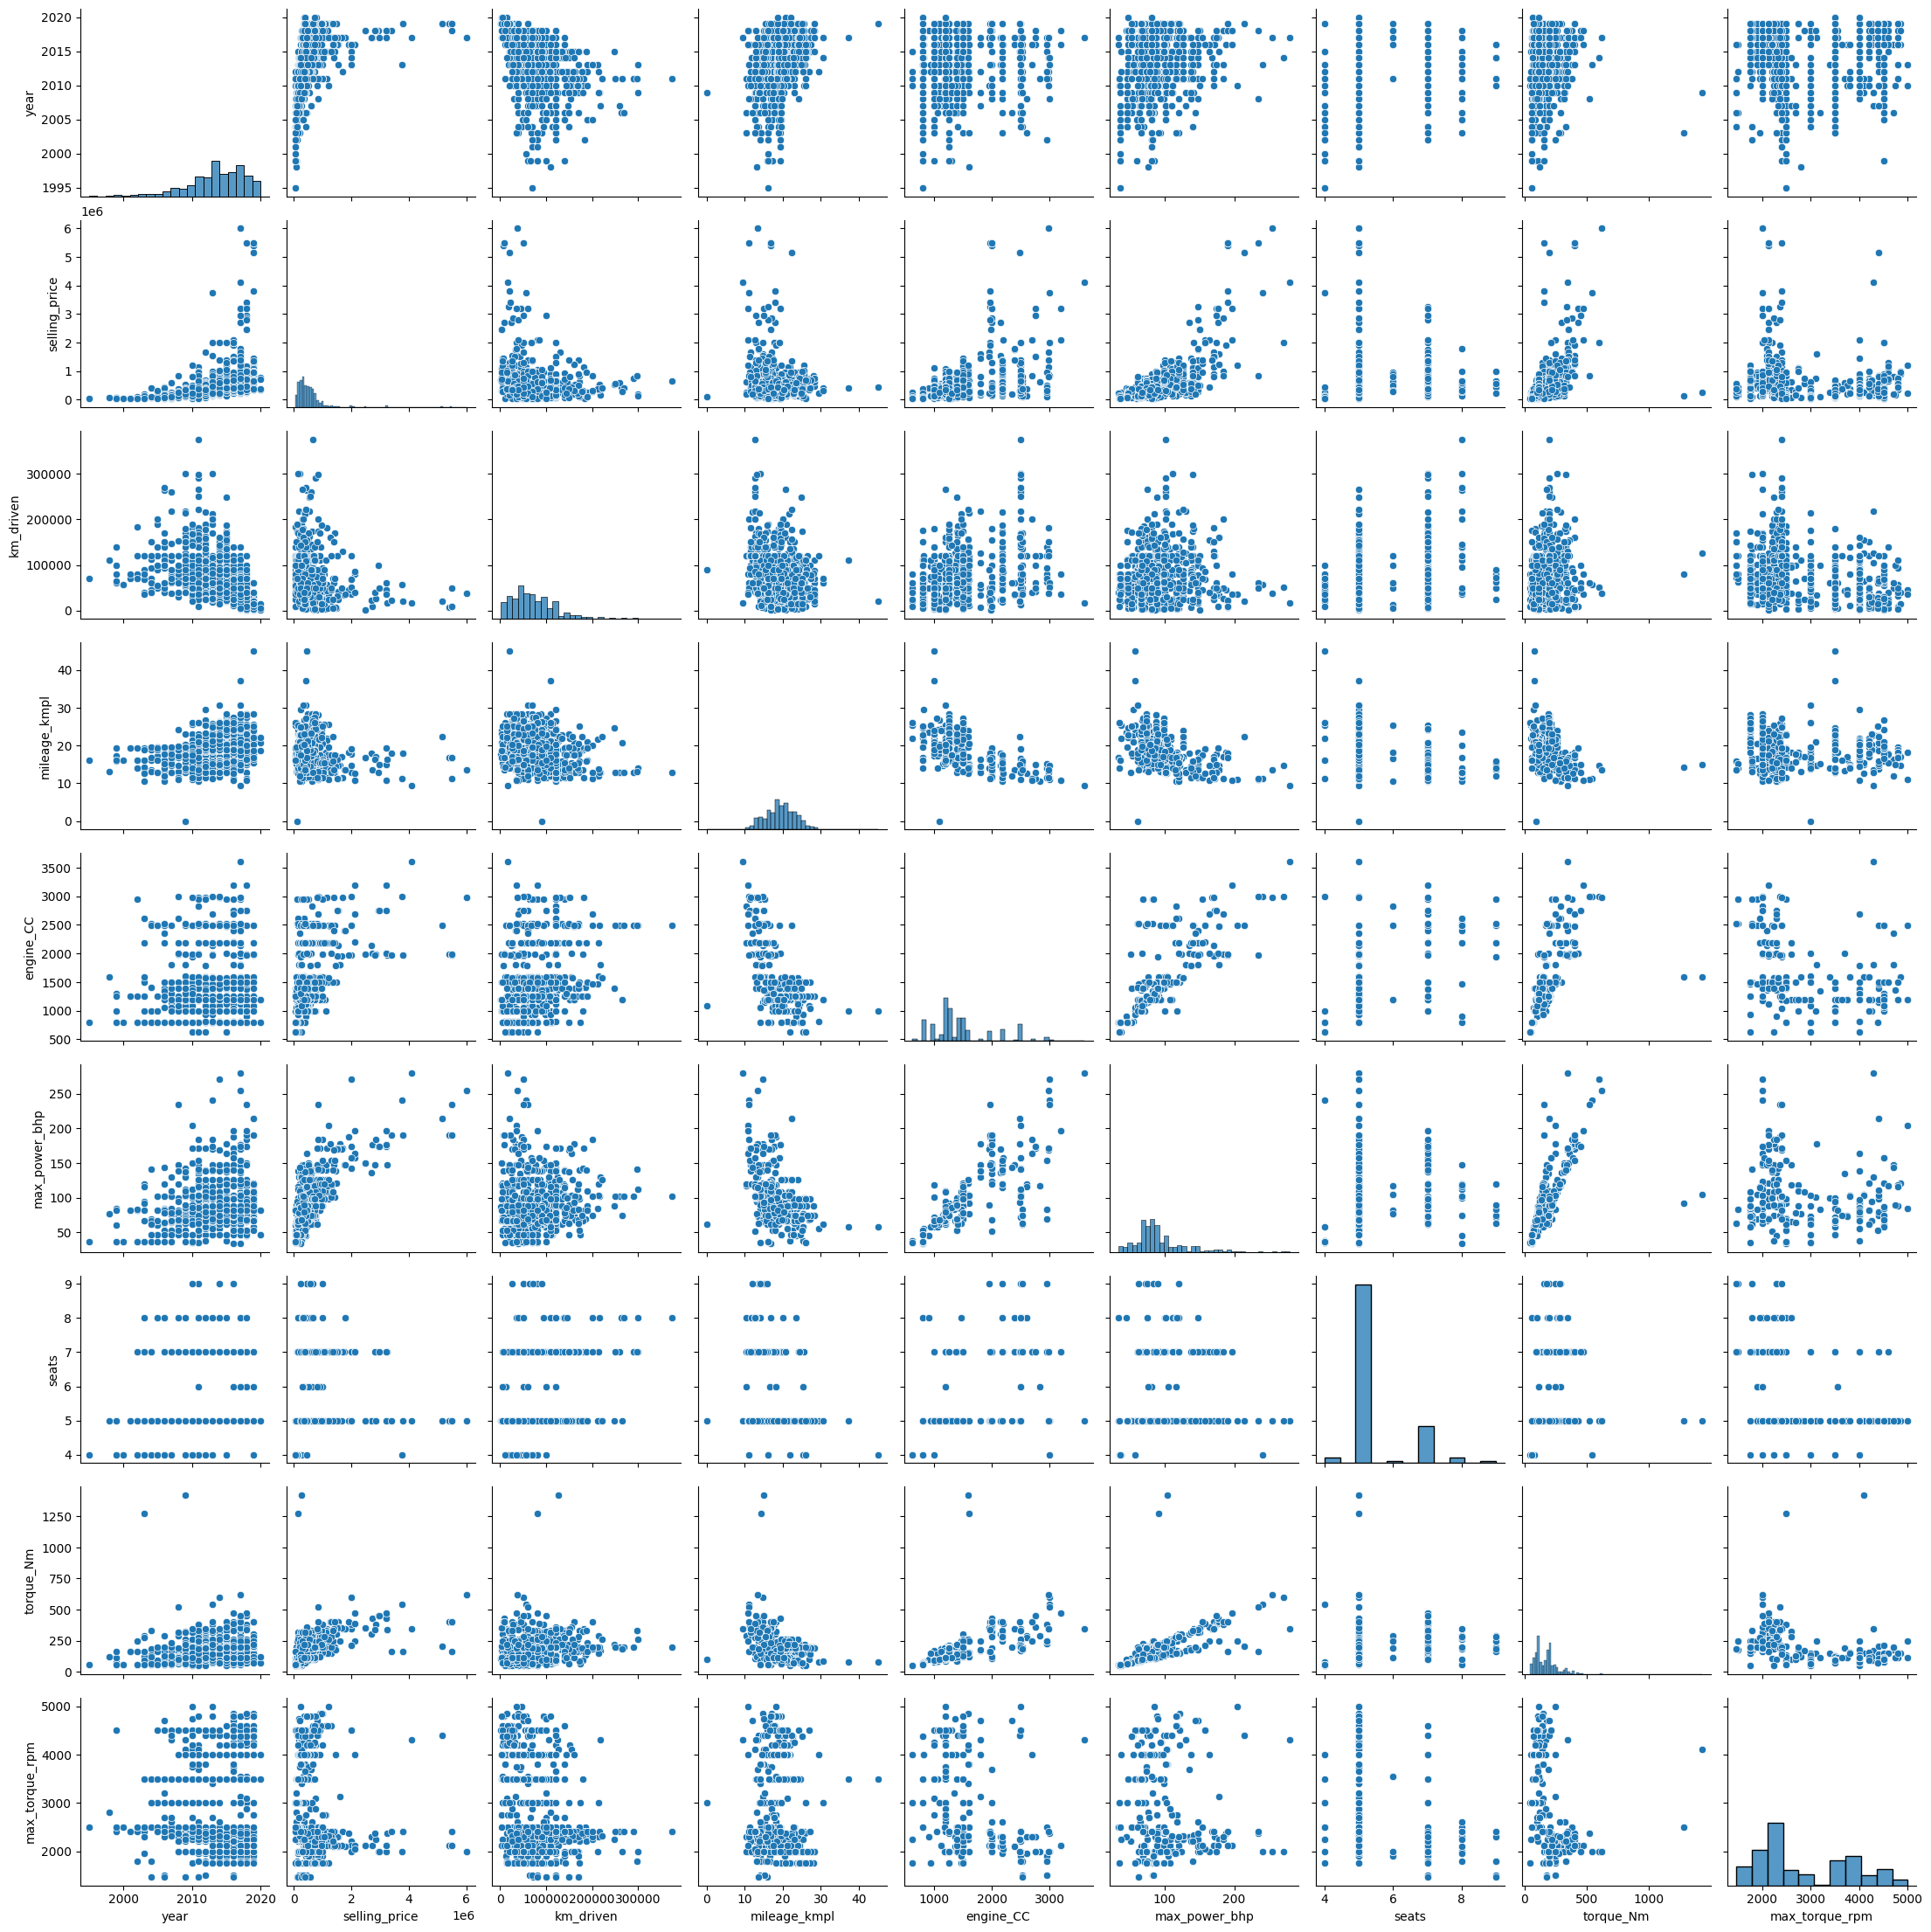

In [534]:
sns.pairplot(df_test)

Тестовый похожи на трейн.

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

<Axes: >

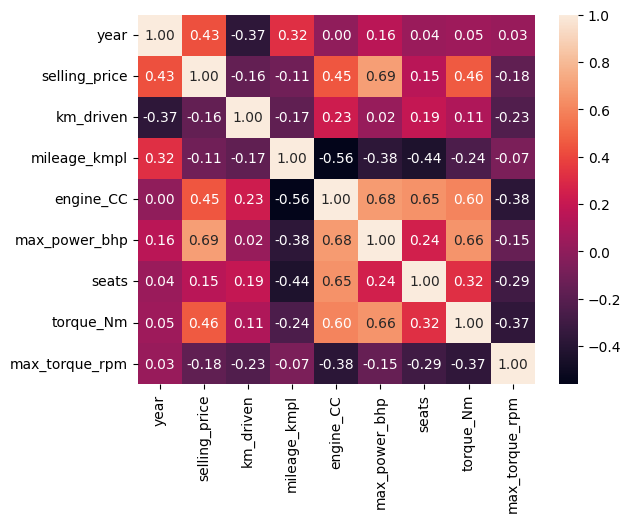

In [537]:
sns.heatmap(df_train.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f")

In [538]:
df_train.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage_kmpl', 'engine_CC', 'max_power_bhp',
       'seats', 'torque_Nm', 'max_torque_rpm'],
      dtype='object')

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

Самая высокая корреляция между selling_price <-> max_power_bhp  
  
Высокая пол. корр  
max_power_bhp <-> torque_Nm  
engine_CC <-> torque_Nm  
max_power_bhp <-> selling_price  
torque_Nm <-> selling_price  
max_power_bhp <-> torque_Nm  
engine_CC <-> selling_price  
year <-> selling_price  
  
  
Утверждать нельзя, но корреляция значимая. Можно предположить, что не имея   
данных, что цена будет ниже при увеличении возраста машины  

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [541]:
import numpy as np

def spearman_correlation(x, y):
    rank_x, rank_y = np.argsort(np.argsort(x)), np.argsort(np.argsort(y))
    d = rank_x - rank_y
    spearman_corr = 1 - (6 * np.sum(d**2)) / (len(x) * (len(x)**2 - 1))
    return spearman_corr

In [542]:
from scipy.stats import spearmanr

In [543]:
df_train.selling_price.values

array([300000, 225000, 360000, ..., 515000, 850000, 330000])

In [544]:
spearman_correlation(df_train.year.values, df_train.selling_price.values), spearmanr(df_train.year.values, df_train.selling_price.values).statistic
# Даже близко)

(np.float64(0.7049718374947882), np.float64(0.7072920977139139))

In [545]:
from phik import resources, report

In [546]:
df_train.select_dtypes(include=np.number).phik_matrix()

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage_kmpl', 'engine_CC', 'max_power_bhp', 'seats', 'torque_Nm', 'max_torque_rpm']


year  selling_price  km_driven  mileage_kmpl  engine_CC  \
year            1.000000       0.219841   0.081574      0.277748   0.213156   
selling_price   0.219841       1.000000   0.000000      0.448047   0.503682   
km_driven       0.081574       0.000000   1.000000      0.181072   0.210747   
mileage_kmpl    0.277748       0.448047   0.181072      1.000000   0.661967   
engine_CC       0.213156       0.503682   0.210747      0.661967   1.000000   
max_power_bhp   0.381639       0.872166   0.000000      0.530279   0.720780   
seats           0.288178       0.196447   0.096223      0.523230   0.603400   
torque_Nm       0.185090       0.686445   0.000000      0.293379   0.609265   
max_torque_rpm  0.249873       0.241683   0.047234      0.281646   0.635429   

                max_power_bhp     seats  torque_Nm  max_torque_rpm  
year                 0.381639  0.288178   0.185090        0.249873  
selling_price        0.872166  0.196447   0.686445        0.241683  
km_driven            0.000000  0.096223   0.000000        0.047234  
mileage_kmpl         0.530279  0.523230   0.293379        0.281646  
engine_CC            0.720780  0.603400   0.609265        0.635429  
max_power_bhp        1.000000  0.569587   0.824723        0.298986  
seats                0.569587  1.000000   0.366256        0.330609  
torque_Nm            0.824723  0.366256   1.000000        0.954549  
max_torque_rpm       0.298986  0.330609   0.954549        1.000000

Высокая корреляция   
selling_price <-> max_power_bhp  
selling_price <-> torque_Nm  
selling_price <-> engine_CC  
mileage_kmpl <-> engine_CC  
max_power_bhp <-> engine_CC  
seats <-> engine_CC  
torque_Nm <-> max_torque_rpm  

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [550]:
y_train = df_train['selling_price'].copy()
X_train = df_train.select_dtypes(include=np.number).copy().drop(['selling_price', 'max_torque_rpm'], axis=1)

drop т.к. max_torque_rpm сильно коррелирует с torque_Nm

In [552]:
# assert X_train.shape == (5840, 6)

In [553]:
y_test = df_test['selling_price'].copy()
X_test = df_test.select_dtypes(include=np.number).copy().drop(['selling_price', 'max_torque_rpm'], axis=1)

In [554]:
#assert X_test.shape == (1000, 6)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [555]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

reg_0 = LinearRegression().fit(X_train, y_train)
# your code here

In [556]:
print(f'R2 train: {r2_score(y_train, reg_0.predict(X_train))}')
print(f'MSE train: {MSE(y_train, reg_0.predict(X_train))}')
print()
print(f'R2 test: {r2_score(y_test, reg_0.predict(X_test))}')
print(f'MSE test: {MSE(y_test, reg_0.predict(X_test))}')


R2 train: 0.5932977387884217
MSE train: 116246054258.21603

R2 test: 0.5933152357237161
MSE test: 233774015649.0975


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [557]:
def r2_score_custom(y_true, y_pred):
    ss_total = ((y_true - y_true.mean())**2).mean()
    # ss_total показывает на сколько сильно изменчива target по отношению к её среднему
    # чем выше тем больше разброс в данных и шире распределение

    ss_result = ((y_true - y_pred)**2).mean()
    # ss_result показывает на сколько сильно модель ошибвается при предиктах target

    r2 = 1 - ss_result / ss_total
    # r2 показывает на сколько сильно наша модель описывает дисперсию target
    return r2

In [558]:
r2_score_custom(y_test, reg_0.predict(X_test))

np.float64(0.5933152357237161)

### **Бонус (0.15 балла)**|

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [559]:
def adjusted_r2_score(y_true, y_pred, p):
    r2 = r2_score_custom(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2)*(len(y_true) - 1) / (len(y_true) - p - 1))
    return adjusted_r2

In [560]:
adjusted_r2_score(y_test, reg_0.predict(X_test), len(X_test.columns))

np.float64(0.5904454843628956)

Используется дял сравнения моделей, чтобы нормализовать изменение кол-ва признаков  
и если разный размер тестовых выборок.  

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [563]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
# your code here

StandardScaler()

In [564]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

reg_1 = LinearRegression().fit(X_train_sc, y_train)
# your code here

In [565]:
print(f'R2 train: {r2_score(y_train, reg_1.predict(X_train_sc))}')
print(f'MSE train: {MSE(y_train, reg_1.predict(X_train_sc))}')
print()
print(f'R2 test: {r2_score(y_test, reg_1.predict(X_test_sc))}')
print(f'MSE test: {MSE(y_test, reg_1.predict(X_test_sc))}')


R2 train: 0.593297738788422
MSE train: 116246054258.21599

R2 test: 0.5933152357237235
MSE test: 233774015649.09326


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [566]:
X_train.columns[np.argmax(reg_1.coef_)]

'max_power_bhp'

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [568]:
from sklearn.linear_model import Lasso

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

lasso_0 = Lasso().fit(X_train_sc, y_train)
# your code here
print(f'R2 train: {r2_score(y_train, lasso_0.predict(X_train_sc))}')
print(f'MSE train: {MSE(y_train, lasso_0.predict(X_train_sc))}')
print()
print(f'R2 test: {r2_score(y_test, lasso_0.predict(X_test_sc))}')
print(f'MSE test: {MSE(y_test, lasso_0.predict(X_test_sc))}')


R2 train: 0.5932977387603855
MSE train: 116246054266.22954

R2 test: 0.5933141293930446
MSE test: 233774651599.55945


In [569]:
lasso_0.coef_

array([154564.34920054, -44396.20027071,  25984.74571081,  56663.09838501,
       314011.4383341 , -25056.52815694,  16236.85672304])

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [570]:
from sklearn.model_selection import GridSearchCV
alpha_range = np.arange(0.01, 5000.0, 10.0)
cv = 10
lasso_1 = Lasso(random_state = 42)
param = {'alpha':alpha_range}
grid_mse = GridSearchCV(lasso_1, param_grid=param, cv=cv, scoring ='neg_mean_squared_error')

In [571]:
f'{alpha_range.shape[0]*cv} моделей'

'5000 моделей'

In [572]:
grid_mse.fit(X_train_sc, y_train)

GridSearchCV(cv=10, estimator=Lasso(random_state=42),
             param_grid={'alpha': array([1.00000e-02, 1.00100e+01, 2.00100e+01, 3.00100e+01, 4.00100e+01,
       5.00100e+01, 6.00100e+01, 7.00100e+01, 8.00100e+01, 9.00100e+01,
       1.00010e+02, 1.10010e+02, 1.20010e+02, 1.30010e+02, 1.40010e+02,
       1.50010e+02, 1.60010e+02, 1.70010e+02, 1.80010e+02, 1.90010e+02,
       2.00010e+02, 2.10010e+02, 2.20010...
       4.70001e+03, 4.71001e+03, 4.72001e+03, 4.73001e+03, 4.74001e+03,
       4.75001e+03, 4.76001e+03, 4.77001e+03, 4.78001e+03, 4.79001e+03,
       4.80001e+03, 4.81001e+03, 4.82001e+03, 4.83001e+03, 4.84001e+03,
       4.85001e+03, 4.86001e+03, 4.87001e+03, 4.88001e+03, 4.89001e+03,
       4.90001e+03, 4.91001e+03, 4.92001e+03, 4.93001e+03, 4.94001e+03,
       4.95001e+03, 4.96001e+03, 4.97001e+03, 4.98001e+03, 4.99001e+03])},
             scoring='neg_mean_squared_error')

In [573]:
print(f'R2 train: {r2_score(y_train, grid_mse.best_estimator_.predict(X_train_sc))}')
print(f'MSE train: {MSE(y_train, grid_mse.best_estimator_.predict(X_train_sc))}')
print()
print(f'R2 test: {r2_score(y_test, grid_mse.best_estimator_.predict(X_test_sc))}')
print(f'MSE test: {MSE(y_test, grid_mse.best_estimator_.predict(X_test_sc))}')

R2 train: 0.5932224275931416
MSE train: 116267580151.05644

R2 test: 0.5915783958194178
MSE test: 234772400822.66043


**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [575]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
alpha_range = np.arange(0.0, 5000.0, 25.0)
l1_ratio = np.arange(0.05, 1.05, 0.05)
tol = [1e-4, 1e-3, 1e-2]
cv = 10
elastic_net_1 = ElasticNet(random_state = 42)
param = {
    'alpha': alpha_range,
    'l1_ratio': l1_ratio,
    'tol': tol
    }
grid_mse = GridSearchCV(elastic_net_1, param_grid=param, cv=cv, scoring ='neg_mean_squared_error')

In [576]:
f'{alpha_range.shape[0]*cv*l1_ratio.shape[0]*len(tol)} моделей'

'120000 моделей'

In [577]:
grid_mse.fit(X_train_sc, y_train)

/home/jovyan/stanishevskiy/envs/mag/lib/python3.10/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/jovyan/stanishevskiy/envs/mag/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/jovyan/stanishevskiy/envs/mag/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.878e+14, tolerance: 1.434e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.li

GridSearchCV(cv=10, estimator=ElasticNet(random_state=42),
             param_grid={'alpha': array([   0.,   25.,   50.,   75.,  100.,  125.,  150.,  175.,  200.,
        225.,  250.,  275.,  300.,  325.,  350.,  375.,  400.,  425.,
        450.,  475.,  500.,  525.,  550.,  575.,  600.,  625.,  650.,
        675.,  700.,  725.,  750.,  775.,  800.,  825.,  850.,  875.,
        900.,  925.,  950.,  975., 1000., 1025., 1050., 1075., 1100.,
       1125., 1150., 1175., 1200., 1225., 1250., 1275....
       4050., 4075., 4100., 4125., 4150., 4175., 4200., 4225., 4250.,
       4275., 4300., 4325., 4350., 4375., 4400., 4425., 4450., 4475.,
       4500., 4525., 4550., 4575., 4600., 4625., 4650., 4675., 4700.,
       4725., 4750., 4775., 4800., 4825., 4850., 4875., 4900., 4925.,
       4950., 4975.]),
                         'l1_ratio': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='neg_mean_squared_error')

In [578]:
print(f'R2 train: {r2_score(y_train, grid_mse.best_estimator_.predict(X_train_sc))}')
print(f'MSE train: {MSE(y_train, grid_mse.best_estimator_.predict(X_train_sc))}')
print()
print(f'R2 test: {r2_score(y_test, grid_mse.best_estimator_.predict(X_test_sc))}')
print(f'MSE test: {MSE(y_test, grid_mse.best_estimator_.predict(X_test_sc))}')

R2 train: 0.5932324950234016
MSE train: 116264702618.38484

R2 test: 0.5917301467540643
MSE test: 234685170052.0808


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [581]:
name_map = [
  "Abarth",
  "Alfa Romeo",
  "Aston Martin",
  "Audi",
  "Bentley",
  "BMW",
  "Bugatti",
  "Cadillac",
  "Chevrolet",
  "Chrysler",
  "Citroën",
  "Dacia",
  "Daihatsu",
  "Dodge",
  "Donkervoort",
  "DS",
  "Ferrari",
  "Fiat",
  "Fisker",
  "Ford",
  "Honda",
  "Hummer",
  "Hyundai",
  "Infiniti",
  "Iveco",
  "Jaguar",
  "Jeep",
  "KTM",
  "Lada",
  "Lamborghini",
  "Lancia",
  "Landwind",
  "Lotus",
  "Maserati",
  "Maybach",
  "Mazda",
  "McLaren",
  "Mercedes-Benz",
  "Mini",
  "Mitsubishi",
  "Morgan",
  "Nissan",
  "Porsche",
  "Renault",
  "Rolls-Royce",
  "Saab",
  "Seat",
  "Skoda",
  "Subaru",
  "Suzuki",
  "Tesla",
  "Toyota",
  "Volkswagen",
  "Volvo",
  'Datsun', 
  'Mahindra', 
  'Maruti', 
  'Tata',
]

In [582]:
def update_name(value):
    for k in name_map:
        if k.lower() in value.lower():
            return k
    else:
        return 'Other'

In [583]:
y_train = df_train['selling_price'].copy()
X_train_cat = df_train.select_dtypes(include='object').copy()
X_train_cat.name = X_train_cat.name.apply(update_name)

y_test = df_test['selling_price'].copy()
X_test_cat = df_test.select_dtypes(include='object').copy()
X_test_cat.name = X_test_cat.name.apply(update_name)

In [585]:
# assert X_train_cat.shape == (5840, 11)

In [586]:
X_train_cat.describe(include='object')

name    fuel seller_type transmission        owner
count     5840    5840        5840         5840         5840
unique      24       4           3            2            5
top     Maruti  Diesel  Individual       Manual  First Owner
freq      1752    3177        5223         5336         3603

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [ ]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas
ohe = OneHotEncoder().fit(X_train_cat)

In [588]:
ohe_df_train = pd.DataFrame(
            ohe.transform(X_train_cat).toarray(), 
            columns=ohe.get_feature_names_out(), 
            dtype=float
            )
ohe_df_test= pd.DataFrame(
            ohe.transform(X_test_cat).toarray(), 
            columns=ohe.get_feature_names_out(), 
            dtype=float
            )

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

Не успользовать столбцы с уникальными данными, группировать признаки, можно кластеризовать и выделять группы  
кол-во степеней свободны  
часто можно дропнуть, и всегда можно сгрупировать их в 1 группу и переобучить модель. Много бесполезных весов, слишком шумят  

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [590]:
total_train_df = np.concatenate([scaler.transform(X_train), ohe_df_train.values], axis=1)
total_test_df = np.concatenate([scaler.transform(X_test), ohe_df_test.values], axis=1)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alpha_range = np.arange(0.01, 5000.0, 10.0)
cv = 10
ridge_1 = Ridge(random_state = 42)
param = {'alpha':alpha_range}
grid_r2 = GridSearchCV(ridge_1, param_grid=param, cv=cv, scoring ='r2')


In [592]:
grid_r2.fit(total_train_df, y_train)

GridSearchCV(cv=10, estimator=Ridge(random_state=42),
             param_grid={'alpha': array([1.00000e-02, 1.00100e+01, 2.00100e+01, 3.00100e+01, 4.00100e+01,
       5.00100e+01, 6.00100e+01, 7.00100e+01, 8.00100e+01, 9.00100e+01,
       1.00010e+02, 1.10010e+02, 1.20010e+02, 1.30010e+02, 1.40010e+02,
       1.50010e+02, 1.60010e+02, 1.70010e+02, 1.80010e+02, 1.90010e+02,
       2.00010e+02, 2.10010e+02, 2.20010...
       4.70001e+03, 4.71001e+03, 4.72001e+03, 4.73001e+03, 4.74001e+03,
       4.75001e+03, 4.76001e+03, 4.77001e+03, 4.78001e+03, 4.79001e+03,
       4.80001e+03, 4.81001e+03, 4.82001e+03, 4.83001e+03, 4.84001e+03,
       4.85001e+03, 4.86001e+03, 4.87001e+03, 4.88001e+03, 4.89001e+03,
       4.90001e+03, 4.91001e+03, 4.92001e+03, 4.93001e+03, 4.94001e+03,
       4.95001e+03, 4.96001e+03, 4.97001e+03, 4.98001e+03, 4.99001e+03])},
             scoring='r2')

In [593]:

print(f'R2 train: {r2_score(y_train, grid_r2.best_estimator_.predict(total_train_df))}')
print(f'MSE train: {MSE(y_train, grid_r2.best_estimator_.predict(total_train_df))}')
print()
print(f'R2 test: {r2_score(y_test, grid_r2.best_estimator_.predict(total_test_df))}')
print(f'MSE test: {MSE(y_test, grid_r2.best_estimator_.predict(total_test_df))}')

R2 train: 0.7560425231169278
MSE train: 69729374038.79808

R2 test: 0.7414758103119883
MSE test: 148607086555.95905


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [594]:
df_train_fe = df_train.copy()
df_test_fe = df_test.copy()

## owner

In [806]:
df_train.owner.unique()

array(['First Owner', 'Third Owner', 'Second Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [807]:
df_train.groupby('owner').count().name#unique()

owner
First Owner             3603
Fourth & Above Owner     140
Second Owner            1639
Test Drive Car             4
Third Owner              454
Name: name, dtype: int64

In [808]:
df_test.groupby('owner').count().name#unique()

owner
First Owner             623
Fourth & Above Owner     27
Second Owner            278
Test Drive Car            1
Third Owner              71
Name: name, dtype: int64

In [809]:
def merge_owner(value):
    if value.strip() not in ['First Owner', 'Second Owner', 'Test Drive Car']:
        return 'Third & Above Owner'
    return value

In [812]:
df_train_fe.owner = df_train_fe.owner.apply(merge_owner)
df_test_fe.owner = df_test_fe.owner.apply(merge_owner)

## extrim values

In [817]:
from scipy import stats
df_train_fe = df_train_fe[(np.abs(stats.zscore(df_train_fe.select_dtypes(include=np.number))) < 3).all(axis=1)].reset_index(drop=True)

## add math fulction

In [884]:
def np_cube(array):
    return np.pow(array, 3)

In [ ]:
def np_outer(x):
    return np.outer(x, x).reshape(-1)

def np_outer_inv(x):
    return np.outer(x, np.reciprocal(x)).reshape(-1)

def np_matrix_outer(matrix):
    return np.apply_along_axis(np_outer, 1, matrix)

def np_matrix_outer_inv(matrix):
    return np.apply_along_axis(np_outer_inv, 1, matrix)



In [905]:
math_func = [np.log, np_cube, np.reciprocal, np.sqrt, np_matrix_outer, np_matrix_outer_inv]

In [909]:
def num_Feature_Engineering(df):
    df_values = df.values
    features_gen = [func(df_values) for func in math_func]
    total_features = [df_values] + features_gen
    return np.concatenate(total_features, axis=1)

## Pipeline

In [440]:
from typing import List
import regex as re
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

In [441]:
final_df_train = df_train.copy()
final_df_test = df_test.copy()

num_columns = ['year', 'km_driven', 'mileage_kmpl', 'engine_CC', 'max_power_bhp', 'seats', 'torque_Nm', 'max_torque_rpm']
cat_columns = ['name', 'fuel', 'seller_type', 'transmission', 'owner']

### help_func

In [442]:
def convert_mileage_engine_max_power(value):
    if isinstance(value, str):
        num_value = re.search('(\d+\.*\d*)', value)
        if num_value is None:
            return None
        else:
            num_value = num_value.group()
        dim_of_value = value.replace(num_value, '').strip()
        if dim_of_value.startswith('km') and dim_of_value.endswith('kg'):
            return float(num_value) * 1.4
        else:
            return float(num_value)
    elif isinstance(value, float | int):
        return float(value)
    else:
        return None  

def split_torque(value):
    if pd.isna(value): return None, None
    res_nums = [float(i.replace(',', '')) for i in re.findall('([0-9]+[.,]*[0-9]*)\D*', value)]
    res_dims = re.findall('[a-zA-Z]+', value)
    assert 1 <= len(res_nums) <= 3
    if len(res_nums) == 2:
        torque_num, max_torque_rpm_num = res_nums[0], res_nums[-1]
    elif len(res_nums) >= 2:
        torque_num, max_torque_rpm_num = res_nums[0], sum(res_nums[-2:])/2
    else:
        torque_num, max_torque_rpm_num = res_nums[0], None
    if len(res_dims) >= 2:
        torque_dim, max_torque_rpm_dim = res_dims[0], res_dims[-1]
    else:
        return None, None
    assert max_torque_rpm_dim.lower() == 'rpm'
    if torque_dim.lower() == 'kgm':
        torque_num *= 9.80665
        torque_dim = 'Nm'
    return torque_num, max_torque_rpm_num

def update_name(value):
    for k in name_map:
        if k.lower() in value.lower():
            return k
    else:
        return 'Other'

def merge_owner(value):
    if value.strip() not in ['First Owner', 'Second Owner', 'Test Drive Car']:
        return 'Third & Above Owner'
    return value

def np_cube(array):
    return np.pow(array, 3)

def np_outer(x):
    return np.outer(x, x).reshape(-1)

def np_outer_inv(x):
    return np.outer(x, np.reciprocal(x)).reshape(-1)

def np_matrix_outer(matrix):
    return np.apply_along_axis(np_outer, 1, matrix)

def np_matrix_outer_inv(matrix):
    return np.apply_along_axis(np_outer_inv, 1, matrix)

math_func = [
    np.log, 
    np_cube, 
    np.reciprocal, 
    np.sqrt, 
    np_matrix_outer, 
    np_matrix_outer_inv
    ]

def num_Feature_Engineering(df):
    df_values = df.values + 1e-6
    features_gen = [func(df_values) for func in math_func]
    total_features = [df_values] + features_gen
    return np.concatenate(total_features, axis=1)

name_map = ['Renault', 'Maruti', 'Hyundai', 'Skoda', 'Ford', 'Fiat',
       'Mahindra', 'Tata', 'Honda', 'Toyota', 'Seat', 'Mercedes-Benz',
       'Jeep', 'Chevrolet', 'Datsun', 'Volkswagen', 'Nissan',
       'BMW', 'Audi', 'Volvo', 'Mitsubishi', 'DS']

def update_name(value):
    for k in name_map:
        if k.lower() in value.lower():
            return k
    else:
        return 'Other'

### num_prep

In [443]:
final_df_train = final_df_train.sample(frac=1.0, random_state=42).drop_duplicates(subset=final_df_train.drop('selling_price', axis=1).columns, keep='first').reset_index(drop=True)

In [444]:
for col in ['mileage', 'engine', 'max_power']:
    final_df_train[col] = final_df_train[col].apply(convert_mileage_engine_max_power)


final_df_train.rename(columns={'max_power':'max_power_bhp', 'engine':'engine_CC', 'mileage':"mileage_kmpl"}, inplace=True)
final_df_train[['torque_Nm', 'max_torque_rpm']] = final_df_train.torque.apply(split_torque).tolist()
final_df_train = final_df_train.drop('torque', axis=1)

median_val = final_df_train.select_dtypes(include=np.number).apply(lambda x: x.median(), axis=0).to_dict()
final_df_train = final_df_train.fillna(value=median_val)

#final_df_train = final_df_train[(np.abs(stats.zscore(final_df_train[num_columns])) < 3).all(axis=1)].reset_index(drop=True)

num_df_train = num_Feature_Engineering(final_df_train[num_columns])


In [446]:
scaler_fe = StandardScaler()
scaler_default = StandardScaler()
scaler_fe.fit(num_df_train)
scaler_default.fit(final_df_train[num_columns])

StandardScaler()

### cat_prep

In [447]:
final_df_train.name = final_df_train.name.apply(update_name)

In [448]:
ohe = OneHotEncoder().fit(final_df_train[cat_columns])

In [449]:
cat_df_train = pd.DataFrame(
            ohe.transform(final_df_train[cat_columns]).toarray(), 
            columns=ohe.get_feature_names_out(), 
            dtype=float
            )

In [450]:
total_train_df_fe = np.concatenate([scaler_fe.transform(num_df_train), cat_df_train], axis=1)
total_train_df_default = np.concatenate([scaler_default.transform(final_df_train[num_columns]), cat_df_train], axis=1)

Подготовка для test

In [451]:
for col in ['mileage', 'engine', 'max_power']:
    final_df_test[col] = final_df_test[col].apply(convert_mileage_engine_max_power)


final_df_test.rename(columns={'max_power':'max_power_bhp', 'engine':'engine_CC', 'mileage':"mileage_kmpl"}, inplace=True)
final_df_test[['torque_Nm', 'max_torque_rpm']] = final_df_test.torque.apply(split_torque).tolist()
final_df_test = final_df_test.drop('torque', axis=1)

median_val = final_df_test.select_dtypes(include=np.number).apply(lambda x: x.median(), axis=0).to_dict()
final_df_test = final_df_test.fillna(value=median_val)

num_df_test = num_Feature_Engineering(final_df_test[num_columns])
final_df_test.name = final_df_test.name.apply(update_name)
cat_df_test = pd.DataFrame(
            ohe.transform(final_df_test[cat_columns]).toarray(), 
            columns=ohe.get_feature_names_out(), 
            dtype=float
            )

total_test_df_fe = np.concatenate([scaler_fe.transform(num_df_test), cat_df_test], axis=1)
total_test_df_default = np.concatenate([scaler_default.transform(final_df_test[num_columns]), cat_df_test], axis=1)

In [452]:
y_train = final_df_train['selling_price'].values
y_test = final_df_test['selling_price'].values

### train models

In [ ]:
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.model_selection import GridSearchCV
models_list = []
cv = 5
model_and_params = {
    'Ridge': (
        Ridge(random_state = 42), 
        {
        'alpha': np.arange(0.01, 1.0, 0.1)
        }),
    'ElasticNet': (
        ElasticNet(random_state = 42), 
        {
            'alpha': np.arange(0.01, 2.0, 0.5), 
            'l1_ratio': np.arange(0.01, 1.0, 0.25), 
            'tol': [1e-4, 1e-3, 1e-2] 
            }),
    'Lasso': (
        Lasso(random_state = 42), 
        {
        'alpha': np.arange(0.01, 1.0, 0.1)
        })
}
for target_metric in ['r2', 'neg_mean_squared_error']:
    for df_prep, _df_train, _df_test in zip(['fe', 'default'], [total_train_df_fe, total_train_df_default], [total_test_df_fe, total_test_df_default]):
        print(f'TARGET METRIC: {target_metric}', f'df_prep: {df_prep}')
        for model_type, (model, params) in model_and_params.items():
            print(f'\tTrain {model_type}')
            _grid = GridSearchCV(model, param_grid=params, cv=cv, scoring = target_metric, verbose = False)
            _grid.fit(_df_train, y_train)
            models_list.append({
                    'model_type': model_type,
                    'model': _grid.best_estimator_,
                    'df_prep': df_prep,
                    'cv': cv,
                    'target_metric': target_metric, 
                    'r2_train': r2_score(y_train, _grid.best_estimator_.predict(_df_train)),
                    'r2_test': r2_score(y_test, _grid.best_estimator_.predict(_df_test)),
                    'MSE_train': MSE(y_train, _grid.best_estimator_.predict(_df_train)),
                    'MSE_test': MSE(y_test, _grid.best_estimator_.predict(_df_test))
                })


# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [ ]:
def business_metrics(y_true, y_pred):
    return (np.absolute(y_pred - y_true) / y_true <= 0.1).mean()


In [475]:
for sample in models_list:
    train_metric = business_metrics(y_train, sample['model'].predict(total_train_df_fe if sample['df_prep'] == 'fe' else total_train_df_default))
    test_metric = business_metrics(y_test, sample['model'].predict(total_test_df_fe if sample['df_prep'] == 'fe' else total_test_df_default))
    sample.update({'business_metrics_train': train_metric, 'business_metrics_test': test_metric})
    print(sample['model_type'], sample['df_prep'], train_metric, test_metric)

Ridge fe 0.29948630136986304 0.324
ElasticNet fe 0.26352739726027397 0.277
Lasso fe 0.2905821917808219 0.31
Ridge default 0.2654109589041096 0.278
ElasticNet default 0.24537671232876712 0.265
Lasso default 0.26746575342465756 0.283
Ridge fe 0.29948630136986304 0.324
ElasticNet fe 0.26352739726027397 0.277
Lasso fe 0.2905821917808219 0.31
Ridge default 0.2654109589041096 0.278
ElasticNet default 0.24537671232876712 0.265
Lasso default 0.26746575342465756 0.283


### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [ ]:
def your_business_metrics(y_true, y_pred):
    d = (y_pred - y_true) / y_true
    d[d < -0.0] *= 1.25
    return (np.absolute(d) <= 0.1).mean()

In [476]:
for sample in models_list:
    train_metric = your_business_metrics(y_train, sample['model'].predict(total_train_df_fe if sample['df_prep'] == 'fe' else total_train_df_default))
    test_metric = your_business_metrics(y_test, sample['model'].predict(total_test_df_fe if sample['df_prep'] == 'fe' else total_test_df_default))
    sample.update({'your_business_metrics_train': train_metric, 'your_business_metrics_test': test_metric})
    print(sample['model_type'], sample['df_prep'], train_metric, test_metric)

Ridge fe 0.2678082191780822 0.295
ElasticNet fe 0.2356164383561644 0.25
Lasso fe 0.25924657534246576 0.28
Ridge default 0.23852739726027397 0.248
ElasticNet default 0.21986301369863015 0.238
Lasso default 0.24092465753424658 0.254
Ridge fe 0.2678082191780822 0.295
ElasticNet fe 0.2356164383561644 0.25
Lasso fe 0.25924657534246576 0.28
Ridge default 0.23852739726027397 0.248
ElasticNet default 0.21986301369863015 0.238
Lasso default 0.24092465753424658 0.254


Лучшая модель Ridge + Feature Engineering обученная на r2 или MSE  

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:    
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>